Graph Structure:


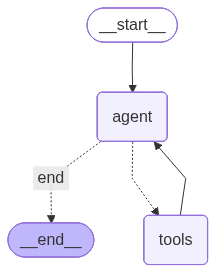

In [3]:
import os
from typing import Literal
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("OPENAI_API_KEY")
BASE_URL = os.getenv("BASE_URL")

# ========== 定义工具函数 ==========
@tool
def get_weather(location: str):
    """Get the current weather for a specific location.
    
    Args:
        location: The city name or location to get weather for
    """
    location_lower = location.lower()
    if "san francisco" in location_lower or "sf" in location_lower:
        return "It's 16 degrees and foggy in San Francisco."
    elif "new york" in location_lower or "ny" in location_lower:
        return "It's 25 degrees and sunny in New York."
    elif "tokyo" in location_lower:
        return "It's 20 degrees and cloudy in Tokyo."
    else:
        return f"It's 22 degrees and partly cloudy in {location}."

@tool
def get_coolest_cities():
    """Get a list of the coolest cities to visit.
    Use this when someone asks for travel recommendations or coolest cities.
    """
    cities = [
        "San Francisco - Known for tech, Golden Gate Bridge, and foggy weather",
        "Tokyo - Amazing food, culture, and technology",
        "Barcelona - Beautiful architecture and beaches",
        "New York - The city that never sleeps",
        "Paris - City of lights and romance"
    ]
    return "\n".join(cities)

# 工具函数列表
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

model_with_tools = ChatOpenAI(
    model="Qwen/Qwen2.5-7B-Instruct",
    api_key=API_KEY,
    base_url=BASE_URL,
    temperature=0
).bind_tools(tools)

# ========== 构建LangGraph ==========
workflow = StateGraph(MessagesState)

# 定义系统提示
system_message = SystemMessage(
    content="""You are a helpful assistant with access to tools.
When users ask about weather, use the get_weather tool.
When users ask about cool cities or travel recommendations, use the get_coolest_cities tool.
Always use the appropriate tool to provide accurate information."""
)

# 定义agent节点
def call_model(state: MessagesState):
    """调用模型，模型会决定是否使用工具"""
    messages = state["messages"]
    
    # 如果没有系统消息，添加一个
    if not any(isinstance(m, SystemMessage) for m in messages):
        messages = [system_message] + messages
    
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

# 定义条件路由函数
def should_continue(state: MessagesState) -> Literal["tools", "end"]:
    """决定是否调用工具或结束
    
    如果最后一条消息包含tool_calls，则路由到tools节点
    否则，结束执行
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # 检查最后一条消息是否包含工具调用
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        print(f"🔧 Tool calls detected: {len(last_message.tool_calls)} tool(s) to execute")
        return "tools"
    else:
        print("✅ No tool calls, ending execution")
        return "end"

# 添加节点
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 设置入口点
workflow.add_edge(START, "agent")

# 添加条件边：从agent节点根据条件路由
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # 如果需要调用工具，路由到tools节点
        "end": END         # 如果不需要调用工具，结束
    }
)

# 工具执行后返回agent节点，让模型生成最终答案
workflow.add_edge("tools", "agent")

# 编译图
app = workflow.compile()

# 显示图结构
print("Graph Structure:")
display(Image(app.get_graph().draw_mermaid_png()))


In [6]:
output = app.invoke({"messages": [HumanMessage(content="What's the weather in San Francisco?")]})
print(output["messages"][-1].content)

🔧 Tool calls detected: 1 tool(s) to execute
✅ No tool calls, ending execution
It's currently 16 degrees and foggy in San Francisco.


In [4]:
# ========== 测试用例 ==========
print("\n" + "="*80)
print("TEST 1: Weather Query")
print("="*80)
inputs1 = {"messages": [HumanMessage(content="What's the weather in San Francisco?")]}
for output in app.stream(inputs1):
    for key, value in output.items():
        print(f"\n📍 Node: {key}")
        if "messages" in value:
            for msg in value["messages"]:
                print(f"   Type: {msg.__class__.__name__}")
                if hasattr(msg, "content"):
                    print(f"   Content: {msg.content}")
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    print(f"   Tool Calls: {msg.tool_calls}")
        print("-" * 80)

print("\n" + "="*80)
print("TEST 2: Cool Cities Query")
print("="*80)
inputs2 = {"messages": [HumanMessage(content="What are the coolest cities to visit?")]}
for output in app.stream(inputs2):
    for key, value in output.items():
        print(f"\n📍 Node: {key}")
        if "messages" in value:
            for msg in value["messages"]:
                print(f"   Type: {msg.__class__.__name__}")
                if hasattr(msg, "content"):
                    print(f"   Content: {msg.content}")
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    print(f"   Tool Calls: {msg.tool_calls}")
        print("-" * 80)

print("\n" + "="*80)
print("TEST 3: General Query (No Tool Needed)")
print("="*80)
inputs3 = {"messages": [HumanMessage(content="Hello! How are you?")]}
for output in app.stream(inputs3):
    for key, value in output.items():
        print(f"\n📍 Node: {key}")
        if "messages" in value:
            for msg in value["messages"]:
                print(f"   Type: {msg.__class__.__name__}")
                if hasattr(msg, "content"):
                    print(f"   Content: {msg.content}")
        print("-" * 80)


TEST 1: Weather Query
🔧 Tool calls detected: 1 tool(s) to execute

📍 Node: agent
   Type: AIMessage
   Content: 
   Tool Calls: [{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': '019a3000b650ada8e121d0b1302213de', 'type': 'tool_call'}]
--------------------------------------------------------------------------------

📍 Node: tools
   Type: ToolMessage
   Content: It's 16 degrees and foggy in San Francisco.
--------------------------------------------------------------------------------
✅ No tool calls, ending execution

📍 Node: agent
   Type: AIMessage
   Content: It's currently 16 degrees and foggy in San Francisco.
--------------------------------------------------------------------------------

TEST 2: Cool Cities Query
🔧 Tool calls detected: 1 tool(s) to execute

📍 Node: agent
   Type: AIMessage
   Content: 
   Tool Calls: [{'name': 'get_coolest_cities', 'args': {}, 'id': '019a3000baab4e2559aa7c74270224b0', 'type': 'tool_call'}]
---------------------------------